© 2022 grdnr13 <grdnr17@gmail.com>



---


## 2-1. Decision trees with Breast cancer dataset


---



Data importing

In [154]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

## Goal: Change the "DecisionTree" class to use the gini importance (aka impurity) in the quality test for the node decision.

  1. Update the `DecisionTree` class to use `_gini_importance` and `impurity_decrease` rather than `_entropy` and `_information_gain`.
  

In [156]:
class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, *, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label
    
    def is_leaf(self):
        return self.label is not None

In [157]:
class DecisionTree:

    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _stop(self, depth):
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False
    '''   
    def _entropy(self, y):
        # np.bincount: Count number of occurrences of each value in array
        weights = np.bincount(y) / len(y)
        entropy = -np.sum([w * np.log2(w) for w in weights if w > 0])
        return entropy
    '''
    def _gini_importance(self,y):
      # np.bincount: Count number of occurrences of each value in array
      weights = np.bincount(y) / len(y)
      gini_importance = 1-np.sum([w*w for w in weights])
      return gini_importance
    
    def _expand_tree(self, X, value):

        # np.argwhere: return indices of X which are less than and equal to value
        # np.flatten: turn multi-dimensional data into vectors
        left_idx = np.argwhere(X <= value).flatten()

        # return indices of X which are greater than 
        right_idx = np.argwhere(X > value).flatten()
        return left_idx, right_idx
    '''
    # information_gain = parent_entropy - children_entropy
    def _information_gain(self, X, y, value):
            parent_entropy = self._entropy(y)

            # expand the tree with X 
            left_idx, right_idx = self._expand_tree(X, value)

            n, n_left, n_right = len(y), len(left_idx), len(right_idx)

            if n_left == 0 or n_right == 0: 
                return 0
            
            # each node has two children (right child and left child)
            children_entropy = (n_left / n) * self._entropy(y[left_idx]) + (n_right / n) * self._entropy(y[right_idx])
            return parent_entropy - children_entropy
    '''    
    def _impurity_decrease(self, X, y, value):
        # gini impurity: the lesser, the better
        parent_gini_impurity = self._gini_importance(y)
        
        # expand the tree with X 
        left_idx, right_idx = self._expand_tree(X, value)
        n, n_left, n_right = len(y), len(left_idx), len(right_idx)
        
        if n_left == 0 or n_right == 0: 
            return 0
        # each node has two children (right child and left child)
        children_gini_impurity = (n_left / n) * self._gini_importance(y[left_idx]) + (n_right / n) * self._gini_importance(y[right_idx])
        return parent_gini_impurity - children_gini_impurity


    def _best_split(self, X, y, features):
        # create split dict in which we record score, feature, and value to keep the split yielding the maximum score 
        split = {'score':- 1, 'feat': None, 'value': None}

        # for each column in 30 columns
        for feat in features:
            # select one feature column
            # example: values in outlook column
            X_feat = X[:, feat] 

            # np.unique: remove duplicates
            # create values 
            values = np.unique(X_feat)

            # for each value in the column
            for value in values:
                
                # compute the information gain 
                score = self._impurity_decrease(X_feat, y, value)

                # Update the split with the maximum score
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['value'] = value
                
        # return the best split with the maximum score (i.e., information gain)
        return split['feat'], split['value']
    
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # 1. Check whether go or stop: use stopping criteria using _stop function
        if self._stop(depth):
            most_common_Label = np.argmax(np.bincount(y))
            return Node(label=most_common_Label)
        
        # 2. find the best split: get the best feature for the current node among 30 features
        # random_f carries shuffled feature indices
        random_f = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_value = self._best_split(X, y, random_f)

        # 3. expand the tree: create the subtrees using the best split
        left_idx, right_idx = self._expand_tree(X[:, best_feat], best_value)

        # 4. grow the left subtree and right subtree recursively
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_feat, best_value, left_child, right_child)
        
    def fit(self, X, y):
        self.root = self._build_tree(X, y)
   
    
    # For the evaluation using the testing set, we need a traverse function
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.label
        
        # recursively traverse the tree (left subtree)
        # node.feature = feature index, so compare X to current node's value
        if x[node.feature] <= node.value:
            return self._traverse_tree(x, node.left)
        
        # recursively traverse the tree (right subtree)
        return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

  2. Train the Decision tree model using your updated `DecisionTree` class using `X_train`

In [158]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

  3. Test the trained model using `X_test` and report the accuracy.

In [159]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [160]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.9385964912280702


As you can see above, the accuracy is about 93.86%



---


## 2-2. RandomForest with Titanic dataset


---



load dataset

In [161]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm' -O titanic.csv

--2022-12-02 11:47:51--  https://docs.google.com/uc?export=download&id=1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm
Resolving docs.google.com (docs.google.com)... 108.177.98.101, 108.177.98.102, 108.177.98.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r5l1p7kc4q26ethrsc6p4hc12r322pn2/1669981650000/12385986347045621890/*/1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm?e=download&uuid=dda66f5b-7539-4f5b-9ac6-6aabbea191e2 [following]
--2022-12-02 11:47:52--  https://doc-0s-7g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r5l1p7kc4q26ethrsc6p4hc12r322pn2/1669981650000/12385986347045621890/*/1Z-IGKwjJ2z-tzJUFa9pWmG3BdMULbTqm?e=download&uuid=dda66f5b-7539-4f5b-9ac6-6aabbea191e2
Resolving doc-0s-7g-docs.googleusercontent.com (doc-0s-7g-docs.googleusercontent.com)... 172.253.117.132, 2607:f8b0

Overview the dataset

*   data source: https://github.com/datasciencedojo/datasets/blob/master/titanic.csv
*   'Survived' indicates whether or not the passenger survived

In [162]:
import pandas as pd
df2 = pd.read_csv('titanic.csv')
df2.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [163]:
print(df2.shape)

(891, 12)


Data preprocessing

In [164]:
print('\nNull Values in data \n{}'.format(df2.isnull().sum()))

print('\nDuplicated values in data {}'.format(df2.duplicated().sum()))


Null Values in data 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Duplicated values in data 0


Preprocess Embarked column

In [165]:
print('Embarkation per ports \n{}'.format(df2['Embarked'].value_counts()))

# since the most common port is Southampton the chances are that the missing one is from there
df2['Embarked'].fillna(value='S', inplace=True)

print('Embarkation per ports after filling \n{}'.format(df2['Embarked'].value_counts()))


Embarkation per ports 
S    644
C    168
Q     77
Name: Embarked, dtype: int64
Embarkation per ports after filling 
S    646
C    168
Q     77
Name: Embarked, dtype: int64


Preprocess Age column

In [166]:
mean_age_miss = df2[df2["Name"].str.contains('Miss.', na=False)]['Age'].mean().round()
mean_age_mrs = df2[df2["Name"].str.contains('Mrs.', na=False)]['Age'].mean().round()
mean_age_mr = df2[df2["Name"].str.contains('Mr.', na=False)]['Age'].mean().round()
mean_age_master = df2[df2["Name"].str.contains('Master.', na=False)]['Age'].mean().round()

print('Mean age of Miss. title {}'.format(mean_age_miss))
print('Mean age of Mrs. title {}'.format(mean_age_mrs))
print('Mean age of Mr. title {}'.format(mean_age_mr))
print('Mean age of Master. title {}'.format(mean_age_master))

def fill_age(name_age):
    
    name = name_age[0]
    age = name_age[1]
    
    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Dr.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age

df2['Age'] = df2[['Name', 'Age']].apply(fill_age,axis=1)

Mean age of Miss. title 22.0
Mean age of Mrs. title 36.0
Mean age of Mr. title 33.0
Mean age of Master. title 5.0


Preprocess Cabin column

In [167]:
df2['Cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in df2['Cabin']])

In [168]:
print('Mean Fare of Cabin B {}'.format(df2[df2['Cabin']=='B']['Fare'].mean()))
print('Mean Fare of Cabin C {}'.format(df2[df2['Cabin']=='C']['Fare'].mean()))
print('Mean Fare of Cabin D {}'.format(df2[df2['Cabin']=='D']['Fare'].mean()))
print('Mean Fare of Cabin E {}'.format(df2[df2['Cabin']=='E']['Fare'].mean()))

def reasign_cabin(cabin_fare):
    
    cabin = cabin_fare[0]
    fare = cabin_fare[1]
    
    if cabin=='X':
        if (fare >= 113.5):
            return 'B'
        if ((fare < 113.5) and (fare > 100)):
            return 'C'
        if ((fare < 100) and (fare > 57)):
            return 'D'
        if ((fare < 57) and (fare > 46)):
            return 'D'
        else:
            return 'X'
    else:
        return cabin
      
df2['Cabin'] = df2[['Cabin', 'Fare']].apply(reasign_cabin, axis=1)

Mean Fare of Cabin B 113.50576382978724
Mean Fare of Cabin C 100.1513406779661
Mean Fare of Cabin D 57.24457575757575
Mean Fare of Cabin E 46.02669375


In [169]:
# Check again if any col holds NULL
print('\nNull Values in data \n{}'.format(df2.isnull().sum()))


Null Values in data 
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


Lastly, change the categorical features into numerical values

In [170]:
categories = {"female": 1, "male": 0}
df2['Sex']= df2['Sex'].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
df2['Embarked']= df2['Embarked'].map(categories)

categories = {"X": 1, "C": 2, "E": 3, "G": 4, "D": 5, "A": 6, "B": 7, "F": 8, "T": 9}
df2['Cabin'] = df2['Cabin'].map(categories)

Drop unnecessary columns

In [171]:
# dropping columns
df2 = df2.drop(['Name','Ticket','PassengerId'], axis=1)

In [172]:
df2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,1,1
1,1,1,1,38.0,1,0,71.2833,2,2
2,1,3,1,26.0,0,0,7.9250,1,1
3,1,1,1,35.0,1,0,53.1000,2,1
4,0,3,0,35.0,0,0,8.0500,1,1


In [173]:
from sklearn.preprocessing import StandardScaler
def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X

## Goal: Train the RandomForest classifier with preprocessed Titanic dataset to determine whether people survive or not.


In [174]:
from sklearn import tree

  1. Split the dataset (train:test=80:20).

In [175]:
X = df2[['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
y = df2['Survived']

In [176]:
x_train, x_test = train_test_split(X, test_size=0.2, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=0)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(712, 8) (179, 8)
(712,) (179,)


  2. Use provided `StandardScaler` function to normalize the data

In [177]:
scaler_samples(x_train, x_test)

(array([[ 0.81925059,  1.37207547,  0.46281194, ..., -0.33167904,
         -0.53044873,  0.99748327],
        [-0.38096838, -0.72882288,  0.0895004 , ..., -0.42640542,
         -0.53044873, -0.56341363],
        [-0.38096838, -0.72882288,  0.0895004 , ...,  0.10261958,
         -0.53044873,  0.99748327],
        ...,
        [ 0.81925059, -0.72882288,  0.23882501, ..., -0.48162887,
         -0.53044873,  2.55838016],
        [ 0.81925059,  1.37207547,  0.46281194, ..., -0.28868112,
         -0.53044873, -0.56341363],
        [-0.38096838, -0.72882288,  2.25470738, ...,  0.14245584,
         -0.53044873, -0.56341363]]),
 array([[ 0.81925059, -0.72882288,  0.23882501, ..., -0.34739758,
         -0.53044873,  0.99748327],
        [ 0.81925059, -0.72882288,  0.23882501, ..., -0.48528755,
         -0.53044873, -0.56341363],
        [ 0.81925059, -0.72882288, -1.70239504, ..., -0.0546496 ,
         -0.53044873,  2.55838016],
        ...,
        [-1.58118735,  1.37207547,  0.0895004 , ...,  

  3. Train the RandomForest model using training data. Use the following parameters:
    *   n_estimators=20, 
    *   criterion="entropy"

In [178]:
from sklearn.ensemble import RandomForestClassifier

Rforest = RandomForestClassifier(criterion='entropy', n_estimators=20)
Rforest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20)

  4. Test the trained model using testing data and report the accuracy and confusion matrix. (Note that to derive the confusion matrix, use scikit-learn library, `sklearn.metrics.confusion_matrix`)

In [179]:
y_pred = Rforest.predict(x_test)
print('Accuracy:', accuracy(y_test, y_pred))

Accuracy: 0.8212290502793296


In [180]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[100,  10],
       [ 22,  47]])

  5. Report the feature rankings with importance scores using the bar plot using barplot provided by `seaborn` library. 

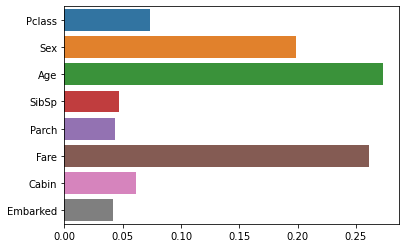

In [181]:
import seaborn as sns

feature_importance = np.array(Rforest.feature_importances_)
feature_names = np.array(x_train.columns)

sns.barplot(x=feature_importance, y=feature_names)

  6. Use hyperparameter tuning with `GridSearchCV` to explore the grid ('n_estimators': [20, 50, 100, 200], 'criterion' :['gini', 'entropy']). Then, report the best parameters, the model accuracy, and confusion matrix. Discuss how much chosen parameters can help improve the model performance in Step 4.

In [182]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

parameters = {'n_estimators': [20, 50, 100, 200], 'criterion':['gini', 'entropy']}
grid_search = GridSearchCV(Rforest, param_grid = parameters)

grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=20),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [20, 50, 100, 200]})

In [183]:
best_params = grid_search.best_estimator_.get_params()

# best parameters
print('Best parameters: ', grid_search.best_params_)

Best parameters:  {'criterion': 'gini', 'n_estimators': 100}


In [189]:
Rforest2 = RandomForestClassifier(criterion='gini', n_estimators=100)
Rforest2.fit(x_train, y_train)
pred2 = Rforest2.predict(x_test)

In [190]:
# model accuracy
acc2 = accuracy(y_test, pred2)
print('Best accuracy: ', acc2)

Best accuracy:  0.8268156424581006


In [186]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[100,  10],
       [ 22,  47]])

### Discuss how much chosen parameters can help improve the model performance in Step 4


A: The accurary went from `0.8212290502793296` in step4 to `0.8268156424581006` in step6. We can see that the accuray increased for about 0.5%
